## CT5135 Research Topics in AI

## Assignment 2

* Student ID(s): 22229358, 22230186, 20230220
* Student name(s): KOSTADIN GEORGIEV, YAMINI GIRKAR, SHUBHAM MANGLAM

### Imports

In [17]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers, models, activations
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

%matplotlib inline 

### Transform Data

Provided images are of different heights so they should be resized to the same resolution.

First, create a function which applies callback to each .jpg image in a directory:

In [2]:
def walk_directory(dir, callback, label=None):
    for dirname, _, filenames in os.walk(dir):
        for filename in filenames:
            if filename.endswith(".jpg"):
                id = filename[:-4]
                pathname = os.path.join(dirname, filename)
                im = Image.open(pathname)
                imnp = np.array(im, dtype=float)

                if len(imnp.shape) != 3:
                    print("This is 1 channel, so we omit it",
                          imnp.shape, filename)
                    continue

                callback(id, imnp, label)

Observe the dimensions of each image in the dataset:

In [3]:
df = pd.DataFrame(columns=['height', 'width', 'channels', 'label'])

def get_img_shape(id, imnp, label):
    height, width, channel = imnp.shape
    df.loc[id] = [height, width, channel, label]

walk_directory('dataset/alpaca', get_img_shape, 'alpaca')
walk_directory('dataset/not_alpaca', get_img_shape, 'not_alpaca')

df

This is 1 channel, so we omit it (683, 1024) 4b9ef3ce2685ee32.jpg
This is 1 channel, so we omit it (914, 1024) 5a71db307230880e.jpg


,height,width,channels,label
01ad3ff1d94eb557,670,1024,3,alpaca
0346463867a297f4,768,1024,3,alpaca
038fae9e70c4c3f1,768,1024,3,alpaca
053608552d63f724,768,1024,3,alpaca
053dab62fbb47736,682,1024,3,alpaca
...,...,...,...,...
eb4d2e0c0252fdc2,682,1024,3,not_alpaca
eb4f5968c7866a3e,699,1024,3,not_alpaca
f4495f8511553631,680,1024,3,not_alpaca
f8d3c3d8be68c4fd,768,1024,3,not_alpaca


In [4]:
IMG_HEIGHT = 28
IMG_WIDTH = 28

print('Images will be resized to', IMG_HEIGHT, 'x', IMG_WIDTH)

Images will be resized to 28 x 28


In [5]:
def resize_images(label):
    source_dir = 'dataset/' + label
    target_dir = 'dataset_resized/'+ label
    subset = df.loc[df['label'] == label]

    for id, image in subset.iterrows():
        id = str(id)
        filename = id + ".jpg"
        
        source_path = os.path.join(source_dir, filename)
        target_path = os.path.join(target_dir, filename)
        
        image = Image.open(source_path)
        image = image.resize((IMG_WIDTH, IMG_HEIGHT), Image.NEAREST)
        image.save(target_path)

In [6]:
resize_images('alpaca')
resize_images('not_alpaca')

### Load Data

In [7]:
def load_images(dir):
    img_array = []
    
    walk_directory(dir, lambda id, imnp, label: img_array.append(imnp))

    return np.array(img_array)

In [8]:
img_alpaca = load_images('dataset_resized/alpaca')
img_not_alpaca = load_images('dataset_resized/not_alpaca')

In [9]:
print('alpaca:', img_alpaca.shape)
print('not_alpaca:', img_not_alpaca.shape)

alpaca: (142, 28, 28, 3)
not_alpaca: (183, 28, 28, 3)


### Pre-Process Data

Create arrays for all images and for all labels:

In [10]:
lbl_alpaca = np.ones(img_alpaca.shape[0], dtype=int)
lbl_not_alpaca = np.zeros(img_not_alpaca.shape[0], dtype=int)
labels = np.concatenate((lbl_alpaca, lbl_not_alpaca), axis=0)
img_array = np.concatenate((img_alpaca, img_not_alpaca), axis=0)
print('img_array:', img_array.shape)
print('labels:', labels.shape)

img_array: (325, 28, 28, 3)
labels: (325,)


Scale down data from 0-255 to 0-1:

In [11]:
img_array_scaled = img_array / 255

Create one-hot encodings for the labels:

In [12]:
labels_one_hot_encode = to_categorical(labels)

### Create Train/Test Splits

Use 80% of the dataset as training data and 20% for testing.

In [13]:
(X_train, X_test,
 y_train, y_test) = train_test_split(img_array_scaled, labels_one_hot_encode,
                                     train_size = 0.8, random_state = 22229358)

### Implement Proposed Layer

#### Diagram of the proposed convolution operation

H = height of input image

W = width of input image

C = number of channels of input

![Proposed Layer](img/proposed_layer.png)

In [36]:
class ProposedLayer(layers.Layer):
    def __init__(self, filters, rf=(3, 3), activation=None, **kwargs):
        super(ProposedLayer, self).__init__(**kwargs)
        self.filters = filters
        self.rf = rf
        self.activation = activations.get(activation)
    
    def build(self, input_shape):
        _, height, width, channels = input_shape

        self.W = self.add_weight(name='kernel',
                                 shape=(height, width, channels, self.filters),
                                 initializer='glorot_uniform',
                                 trainable=True,
                                 dtype=tf.float32)
        self.B = self.add_weight(name='bias',
                                 shape=(self.filters,),
                                 initializer='zeros',
                                 trainable=True,
                                 dtype=tf.float32)
        
        super(ProposedLayer, self).build(input_shape)

    def call(self, inputs):
        batch_size, height, width, _ = inputs.shape
        batch_size = 1 if batch_size is None else batch_size
        z_height = height - self.rf[0] + 1
        z_width = width - self.rf[1] + 1
        output_list = []

        for sample in range(batch_size):
            z_sample = []

            for filter in range(self.filters):
                x = inputs[sample]
                w = self.W[:, :, :, filter]
                b = self.B[filter]
                conv = tf.multiply(x, w) + b
                z_filter = []

                for i in range(z_height):
                    z_rf = []

                    for j in range(z_width):
                        rf = conv[i:i+self.rf[0], j:j+self.rf[1], :]
                        conv_sum = tf.math.reduce_sum(rf)
                        z_rf.append(conv_sum)

                    z_filter.append(z_rf)

                z_sample.append(z_filter)

            output_list.append(z_sample)

        z = tf.stack(output_list)
        
        return self.activation(z)
    
    def compute_output_shape(self, input_shape):
        return tuple(input_shape[0],
                     input_shape[1] - self.rf[0] + 1,
                     input_shape[2] - self.rf[1] + 1,
                     self.filters)

In [15]:
tf.executing_eagerly()

True

### Create Model

#### Model using proposed layer:

In [37]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
n_classes = 2

# Input
inputs = layers.Input(input_shape)

# Block 1
x0 = ProposedLayer(16, (3, 3), activation='relu')(inputs)
x1 = layers.MaxPooling2D((2, 2))(x0)
# Block 2
x2 = ProposedLayer(12, (3, 3), activation='relu')(x1)
x3 = layers.MaxPooling2D((2, 2))(x2)
# Block 3
x4 = ProposedLayer(8, (3, 3), activation='relu')(x3)
x5 = layers.MaxPooling2D((2, 2))(x4)

# Flatten feature map - embedding size will become 32944
x6 = layers.Flatten()(x5)

# Dense layer for classification
# Start with units in dense layer = power of 2 that is
# closest to (embedding_size / 64)
x7 = layers.Dense(512, activation='relu')(x6)
# Output
outputs = layers.Dense(n_classes, activation='softmax')(x7)

proposed_model = keras.Model(inputs, outputs)
proposed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 proposed_layer_22 (Proposed  (1, 16, 26, 26)          37648     
 Layer)                                                          
                                                                 
 max_pooling2d_21 (MaxPoolin  (1, 8, 13, 26)           0         
 g2D)                                                            
                                                                 
 proposed_layer_23 (Proposed  (1, 12, 6, 11)           32460     
 Layer)                                                          
                                                                 
 max_pooling2d_22 (MaxPoolin  (1, 6, 3, 11)            0         
 g2D)                                                        

In [63]:
def init_model(dense_units=512):
    # Input layer
    inputs = layers.Input((IMG_HEIGHT, IMG_WIDTH, 3))
    # Block 1
    x0 = ProposedLayer(16, (3, 3), activation='relu')(inputs)
    x1 = layers.MaxPooling2D((2, 2))(x0)
    # Block 2
    x2 = ProposedLayer(12, (3, 3), activation='relu')(x1)
    x3 = layers.MaxPooling2D((2, 2))(x2)
    # Block 3
    x4 = ProposedLayer(8, (3, 3), activation='relu')(x3)
    x5 = layers.MaxPooling2D((2, 2))(x4)
    # Flatten feature map to produce embedding
    x6 = layers.Flatten()(x5)
    # Dense layer for classification
    x7 = layers.Dense(dense_units, activation='relu')(x6)
    # Output layer
    outputs = layers.Dense(n_classes, activation='softmax')(x7)

    return models.Model(inputs, outputs)

def train_model(model: models.Model, X, y,
                optimizer='Adam', loss='categorical_crossentropy',
                batch_size=1, epochs=1, validation_split = 0.2):
    model.compile(optimizer=optimizer, loss=loss)
    return model.fit(X, y, batch_size, epochs, validation_split = validation_split)

def test_model(model: models.Model, X, y, batch_size=1):
    return model.evaluate(X, y, batch_size)

def plot_history(history, epochs, step):
    plt.figure(1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training loss', 'validation loss'], loc='upper left')
    plt.xlim(0, epochs-1)
    plt.xticks(np.arange(0, epochs, step))
    plt.ylim(0, 1)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid(True)
    plt.rcParams['grid.color'] = (0.1, 0.1, 0.1, 0.1)
    for pos in ['right', 'top', 'bottom', 'left']:
        plt.gca().spines[pos].set_visible(False)
    plt.show()

In [47]:
model = init_model(dense_units=512)
history = train_model(model, X_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
208/208 [==============================] - 398s 448ms/step - loss: 0.7095 - val_loss: 0.6878
Epoch 2/5
208/208 [==============================] - 24s 114ms/step - loss: 0.6883 - val_loss: 0.6825
Epoch 3/5
208/208 [==============================] - 26s 124ms/step - loss: 0.6880 - val_loss: 0.6828
Epoch 4/5
208/208 [==============================] - 25s 121ms/step - loss: 0.6891 - val_loss: 0.6820
Epoch 5/5
208/208 [==============================] - 26s 125ms/step - loss: 0.6878 - val_loss: 0.6827


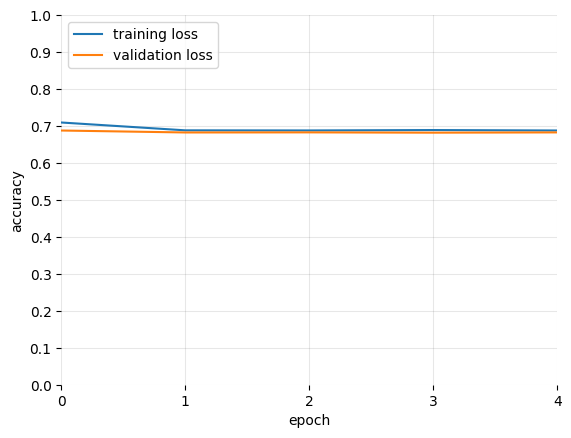

In [59]:
plot_history(history, 5, 1)

In [62]:
test_model(model, X_test, y_test, batch_size=1)

65/65 [==============================] - 3s 51ms/step - loss: 0.6874


0.6873616576194763

In [64]:
model = init_model(dense_units=512)
history = train_model(model, X_train, y_train, batch_size=1, epochs=10, validation_split=0.1)

Epoch 1/10
234/234 [==============================] - 402s 427ms/step - loss: 0.7025 - val_loss: 0.6955
Epoch 2/10
234/234 [==============================] - 29s 125ms/step - loss: 0.6866 - val_loss: 0.7063
Epoch 3/10
234/234 [==============================] - 30s 128ms/step - loss: 0.6851 - val_loss: 0.7040
Epoch 4/10
234/234 [==============================] - 29s 124ms/step - loss: 0.6843 - val_loss: 0.7082
Epoch 5/10
234/234 [==============================] - 29s 126ms/step - loss: 0.6837 - val_loss: 0.6978
Epoch 6/10
234/234 [==============================] - 33s 139ms/step - loss: 0.6865 - val_loss: 0.6985
Epoch 7/10
234/234 [==============================] - 29s 124ms/step - loss: 0.6847 - val_loss: 0.7008
Epoch 8/10
234/234 [==============================] - 30s 127ms/step - loss: 0.6857 - val_loss: 0.7004
Epoch 9/10
234/234 [==============================] - 28s 118ms/step - loss: 0.6858 - val_loss: 0.7025
Epoch 10/10
234/234 [==============================] - 27s 117ms/step - 

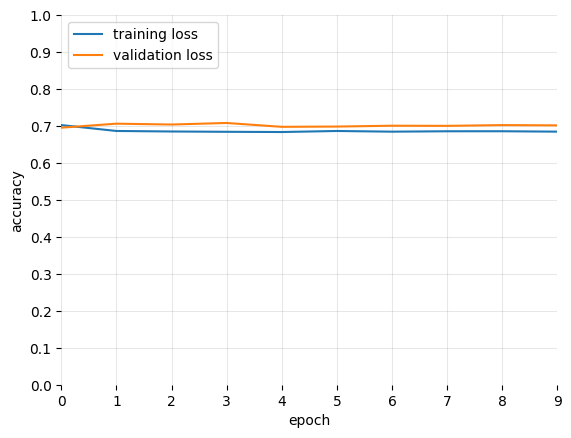

In [68]:
plot_history(history, 10, 1)

In [69]:
test_model(model, X_test, y_test, batch_size=1)

65/65 [==============================] - 4s 57ms/step - loss: 0.6876


0.6875998377799988